In [1]:
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split

In [2]:
train_data = pd.read_csv("data/train_with_embeddings.csv")

In [3]:
# new features
train_data["url_count"] = train_data["urls"].apply(lambda s: s[1:-1].count("\'")/2)
train_data["text_len"] = train_data["text"].apply(lambda s: len(s))
train_data["hashtags_count"] = train_data["hashtags"].apply(lambda s: s[1:-1].count("\'")/2)
train_data["day"] = train_data["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t/1000).day)
train_data["hour"] = train_data["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t/1000).hour)

# indicators of keywords
train_data["Macron"] =  train_data["text"].apply(lambda s: ("macron" in s.lower().split()))
train_data["Zemmour"] =  train_data["text"].apply(lambda s: ("zemmour" in s.lower().split()))
train_data["Melenchon"] =  train_data["text"].apply(lambda s: ("melenchon" in s.replace("é","e").lower().split()))
train_data["rt"] =  train_data["text"].apply(lambda s: ("rt" in s.lower().split()))

In [4]:
display(train_data)

,Unnamed: 0,text,retweets_count,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,...,15,url_count,text_len,hashtags_count,day,hour,Macron,Zemmour,Melenchon,rt
0,0,rt refarcir macron ans nom prépare,3,0,3682,453535,3628,[],[],0,...,-12.226419,0.0,34,0.0,11,5,True,False,False,True
1,1,populaire,0,0,86,1016,284,[],[],0,...,4.243010,0.0,9,0.0,19,12,False,False,False,False
2,2,faut dégager cinglé,3,1,1944,28234,1995,[],[],0,...,-6.869899,0.0,19,0.0,15,18,False,False,False,False
3,3,enseignants mettre prescriptions président rép...,0,0,1,1072,0,[],['https://t.co/rytlted08g'],0,...,-21.181530,1.0,123,0.0,14,11,False,False,False,False
4,4,mafieuse oppressive macron,0,0,13957,25311,10841,[],[],0,...,-4.781973,0.0,26,0.0,14,11,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353964,353964,gonflette tour raciste frustré,0,0,34,1509,55,[],['https://t.co/pma33zhslx'],0,...,4.508761,1.0,30,0.0,16,13,False,False,False,False
353965,353965,france caste crapuleuse encadrée gangsters irr...,0,0,89,11166,127,[],[],0,...,-3.818838,0.0,69,0.0,12,8,False,False,False,False
353966,353966,eric zemmour français berbère,3,0,1888,712,3086,[],[],0,...,1.522889,0.0,29,0.0,18,12,False,True,False,False
353967,353967,gauchistes dépression pq,0,0,139,486,320,[],[],0,...,2.717416,0.0,24,0.0,11,8,False,False,False,False


In [5]:
# select useful columns
train_data_filtered = train_data.drop(["text", "urls", "mentions", "hashtags", "timestamp", "TweetID"], axis=1)
# train_data_filtered = train_data.loc[:, ["retweets_count","favorites_count","followers_count","statuses_count","friends_count",
#                                  "hashtags_count","hour","verified","url_count","text_len","rt","Macron","Zemmour","Melenchon"]]


X_train, X_eval, y_train, y_eval = train_test_split(train_data_filtered.drop("retweets_count", axis=1),
                                                    train_data_filtered["retweets_count"],
                                                    random_state=42, test_size=0.1)

# Standardize the data
normal_columns = train_data_filtered.drop(["hour", "verified", "Macron", "Zemmour", "Melenchon", "url_count", "rt", "retweets_count"], axis=1).columns
mu, sigma = X_train[normal_columns].mean(axis=0), X_train[normal_columns].std(axis=0)
X_train.loc[:, normal_columns] = (X_train[normal_columns] - mu) / sigma
X_eval.loc[:, normal_columns] = (X_eval[normal_columns] - mu) / sigma

In [6]:
import tensorflow as tf

In [7]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(50, activation='relu'),
  tf.keras.layers.Dense(50, activation='relu'),
  tf.keras.layers.Dense(50, activation='relu'),
  tf.keras.layers.Dense(1),
])

2022-12-03 14:40:32.694623: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 14:40:32.697214: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
# import tensorflow_addons as tfa
# optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)
# model.compile(optimizer=optimizer, loss='mae')

In [9]:
model.compile(optimizer="adam", loss='mae')

In [10]:
history = model.fit(X_train.values.astype(np.float32), y_train.values.astype(np.float32), epochs=180, batch_size=1024,
         validation_data=(X_eval.values.astype(np.float32), y_eval.values.astype(np.float32)), shuffle=True)

Epoch 1/180
312/312 [==============================] - 2s 6ms/step - loss: 14.8417 - val_loss: 9.1588
Epoch 2/180
312/312 [==============================] - 2s 5ms/step - loss: 7.5157 - val_loss: 7.1899
Epoch 3/180
312/312 [==============================] - 1s 3ms/step - loss: 7.1712 - val_loss: 7.1093
Epoch 4/180
312/312 [==============================] - 1s 3ms/step - loss: 7.0322 - val_loss: 6.9457
Epoch 5/180
312/312 [==============================] - 1s 5ms/step - loss: 6.9418 - val_loss: 6.7350
Epoch 6/180
312/312 [==============================] - 2s 7ms/step - loss: 6.8503 - val_loss: 6.7732
Epoch 7/180
312/312 [==============================] - 3s 9ms/step - loss: 6.8080 - val_loss: 6.6466
Epoch 8/180
312/312 [==============================] - 3s 9ms/step - loss: 6.7632 - val_loss: 6.5863
Epoch 9/180
312/312 [==============================] - 4s 13ms/step - loss: 6.7243 - val_loss: 6.7067
Epoch 10/180
312/312 [==============================] - 2s 6ms/step - loss: 6.6828 - val_

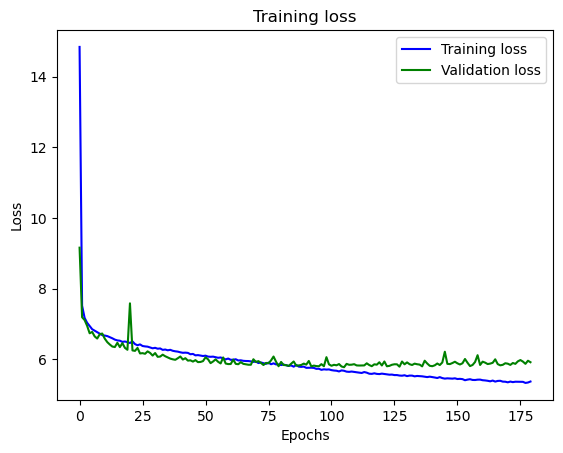

In [11]:
plt.plot(history.epoch, history.history["loss"], 'b', label='Training loss')
plt.plot(history.epoch, history.history["val_loss"], 'g', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
model.evaluate(X_eval.values.astype(np.float32),  y_eval.values.astype(np.float32), verbose=2)

1107/1107 - 1s - loss: 5.9160 - 1s/epoch - 908us/step


5.915964603424072

In [13]:
pred = model.predict(X_train.values.astype(np.float32))
print(pred)

9956/9956 [==============================] - 11s 1ms/step
[[0.02211107]
 [0.85741115]
 [0.00212313]
 ...
 [0.8286927 ]
 [0.02324225]
 [1.1369481 ]]


In [14]:
# plt.scatter(X_train["favorites_count"], model.predict(X_train))
# plt.scatter(X_train["favorites_count"], y_train.values.astype(np.float32))

In [15]:
# evaluation

eval_data = pd.read_csv("data/evaluation_with_embeddings.csv")
tweets = eval_data["TweetID"]

In [16]:
eval_data["url_count"] = eval_data["urls"].apply(lambda s: s[1:-1].count("\'")/2)
eval_data["text_len"] = eval_data["text"].apply(lambda s: len(s))
eval_data["hashtags_count"] = eval_data["hashtags"].apply(lambda s: s[1:-1].count("\'")/2)
eval_data["day"] = eval_data["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t/1000).day)
eval_data["hour"] = eval_data["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t/1000).hour)
eval_data["Macron"] =  eval_data["text"].apply(lambda s: ("macron" in s.lower().split()))
eval_data["Zemmour"] =  eval_data["text"].apply(lambda s: ("zemmour" in s.lower().split()))
eval_data["Melenchon"] =  eval_data["text"].apply(lambda s: ("melenchon" in s.lower().split()))
eval_data["rt"] =  eval_data["text"].apply(lambda s: ("rt" in s.lower().split()))

# print("sentiment analysis...")
# eval_data["compound"] =  eval_data["text"].apply(lambda s: sia.polarity_scores(s)['compound'])

eval_data = eval_data.drop(["text", "urls", "mentions", "hashtags", "timestamp", "TweetID"], axis=1)

# normalize
eval_data.loc[:, normal_columns] = (eval_data.loc[:, normal_columns] - mu) / sigma

print(eval_data)

pred = model.predict(eval_data.values.astype(np.float32))

print(pred)

# output normalization
for i,p in enumerate(pred):
    if p<0: pred[i] = 0

        Unnamed: 0  favorites_count  followers_count  statuses_count  \
0        -1.731691        -0.055089        -0.077561       -0.384487   
1        -1.731681        -0.055089        -0.076250       -0.130940   
2        -1.731672        -0.047990        -0.073569       -0.308274   
3        -1.731662        -0.052722        -0.071378       -0.197070   
4        -1.731652        -0.055089        -0.076932       -0.241396   
...            ...              ...              ...             ...   
117985   -0.577125        -0.055089        -0.077871       -0.421834   
117986   -0.577115        -0.055089        -0.075036       -0.076371   
117987   -0.577105        -0.040891        -0.074347       -0.403582   
117988   -0.577095        -0.055089        -0.077867       -0.423504   
117989   -0.577086        -0.055089        -0.075760       -0.373401   

        friends_count  verified         0         1         2         3  ...  \
0           -0.451430         0 -0.335875  0.285524 -0.

In [17]:
with open("data/predictions.csv", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["TweetID", "retweets_count"])
    for index, prediction in enumerate(pred):
        writer.writerow([str(tweets[index]) , str(int(prediction))])